## Production time series of price anomaly detection

<div style="text-align: right"> <b>Author : Kwang Myung Yu</b></div>

<div style="text-align: right\"> Initial upload: 2020.1.21 </div>
<div style="text-align: right\"> Last update: 2020.1.21</div>

참고자료  
- https://www.kaggle.com/nikitsoftweb/production-time-series-of-price-anomaly-detection   
- https://towardsdatascience.com/time-series-of-price-anomaly-detection-13586cd5ff46

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import warnings; warnings.filterwarnings('ignore')
plt.style.use('ggplot')
%matplotlib inline

In [2]:
colors = ["#00798c", "#d1495b", '#edae49', '#66a182', '#4a4a4a',
          '#1a508b', '#e3120b', '#c5a880', '#9F5F80', '#6F9EAF',
          '#0278ae','#F39233', '#A7C5EB', '#54E346', '#ABCE74',
        '#d6b0b1', '#58391c', '#cdd0cb', '#ffb396', '#6930c3']
sns.color_palette(colors[:10])

[(0.0, 0.4745098039215686, 0.5490196078431373),
 (0.8196078431372549, 0.28627450980392155, 0.3568627450980392),
 (0.9294117647058824, 0.6823529411764706, 0.28627450980392155),
 (0.4, 0.6313725490196078, 0.5098039215686274),
 (0.2901960784313726, 0.2901960784313726, 0.2901960784313726),
 (0.10196078431372549, 0.3137254901960784, 0.5450980392156862),
 (0.8901960784313725, 0.07058823529411765, 0.043137254901960784),
 (0.7725490196078432, 0.6588235294117647, 0.5019607843137255),
 (0.6235294117647059, 0.37254901960784315, 0.5019607843137255),
 (0.43529411764705883, 0.6196078431372549, 0.6862745098039216)]

### 1. 데이터 읽기

데이터 일부만 추출한다.

In [3]:
# expedia = pd.read_csv('train.csv')
# df = expedia.loc[expedia['prop_id'] == 104517]
# df = df.loc[df['srch_room_count'] == 1]
# df = df.loc[df['visitor_location_country_id'] == 219]
# df = df[['date_time', 'price_usd', 'srch_booking_window', 'srch_saturday_night_bool']]

In [4]:
# df.to_csv('expedia.csv', index = False)

In [5]:
df = pd.read_csv('expedia.csv')

In [6]:
df.head()

,date_time,price_usd,srch_booking_window,srch_saturday_night_bool
0,2013-03-14 11:27:28,206.0,99,1
1,2013-01-03 20:48:24,186.0,6,0
2,2013-01-19 16:51:27,61.0,1,0
3,2013-01-26 11:34:23,72.0,116,0
4,2013-04-29 09:39:50,246.0,245,0


In [7]:
df.shape

(3049, 4)

- price_used : 표시된 호텔의 가격  
- srch_booking_window : 검색일로부터 숙박이 시작되는 시점 사이의 날짜 수  
- srch_saturday_night_bool : 숙박에 토요일이 포함되고, 숙박이 목요일부터 시작되서 4일보다 같거나 작으면 1

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3049 entries, 0 to 3048
Data columns (total 4 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   date_time                 3049 non-null   object 
 1   price_usd                 3049 non-null   float64
 2   srch_booking_window       3049 non-null   int64  
 3   srch_saturday_night_bool  3049 non-null   int64  
dtypes: float64(1), int64(2), object(1)
memory usage: 95.4+ KB


In [9]:
df['date_time'] = pd.to_datetime(df['date_time'])

In [10]:
df['price_usd'].describe()

count    3049.000000
mean      112.939023
std       113.374049
min         0.120000
25%        67.000000
50%       100.000000
75%       141.000000
max      5584.000000
Name: price_usd, dtype: float64

- 매우 큰 값이 있다.(5584)

In [11]:
df[df['price_usd']==5584]

,date_time,price_usd,srch_booking_window,srch_saturday_night_bool
932,2013-04-07 20:59:07,5584.0,13,0


이상치를 제거한다.

In [12]:
df = df[df['price_usd']<5584]

### 데이터 시각화

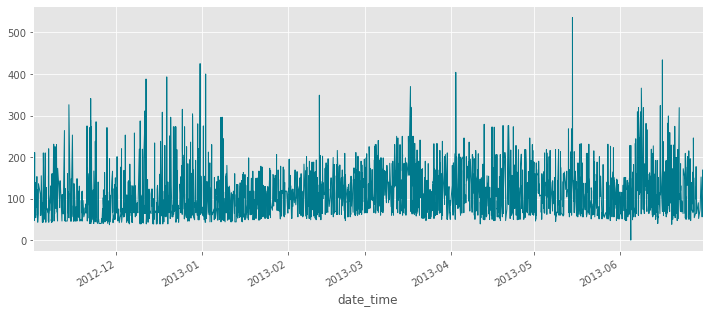

In [13]:
fig, ax = plt.subplots(figsize = (12, 5))
df.set_index('date_time')['price_usd'].plot(ax =ax, color = colors[0], linewidth = 1)
ax.autoscale(enable=True, axis='x', tight=True)
plt.show()

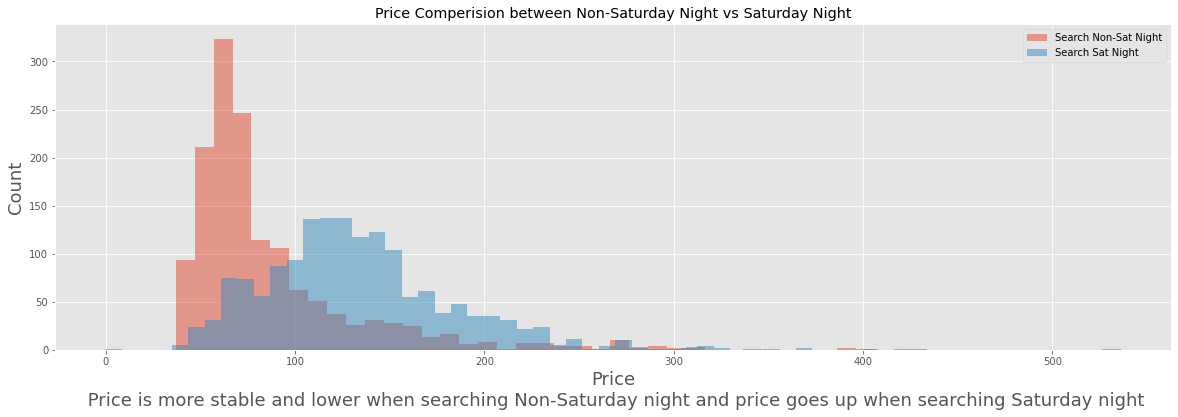

In [14]:
a = df.loc[df['srch_saturday_night_bool'] == 0, 'price_usd']
b = df.loc[df['srch_saturday_night_bool'] == 1, 'price_usd']
plt.figure(figsize=(20, 6))
plt.hist(a, bins = 50, alpha=0.5, label='Search Non-Sat Night')
plt.hist(b, bins = 50, alpha=0.5, label='Search Sat Night')
plt.legend(loc='upper right')
plt.xlabel('Price\n Price is more stable and lower when searching Non-Saturday night and price goes up when searching Saturday night', fontsize = 18)
plt.ylabel('Count', fontsize = 18)
plt.title("Price Comperision between Non-Saturday Night vs Saturday Night")
plt.show();

### Model approach

#### 1. Kmeans

In [15]:
from sklearn.cluster import KMeans

In [16]:
data = df[['price_usd', 'srch_booking_window', 'srch_saturday_night_bool']]

In [17]:
n_cluster = range(1, 20)
kmeans = [KMeans(n_clusters=i).fit(data) for i in n_cluster]
scores = [kmeans[i].score(data) for i in range(len(kmeans))]

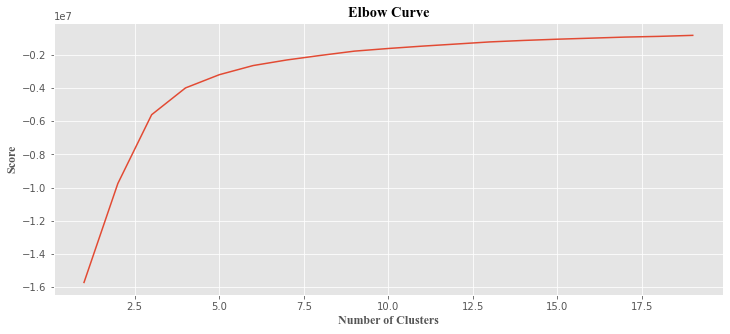

In [18]:
fig, ax = plt.subplots(figsize=(12,5))
ax.plot(n_cluster, scores)
plt.xlabel('Number of Clusters', fontname="Times New Roman",fontweight="bold")
plt.ylabel('Score',fontname="Times New Roman",fontweight="bold")
plt.title("Elbow Curve",fontname="Times New Roman",fontweight="bold")
plt.show();

- 10 cluster 이상에서 score 변동이 적다. cluster를 10으로 설정한다.

In [19]:
X = df[['price_usd', 'srch_booking_window', 'srch_saturday_night_bool']]
X = X.reset_index(drop=True)

In [20]:
X.head()

,price_usd,srch_booking_window,srch_saturday_night_bool
0,206.0,99,1
1,186.0,6,0
2,61.0,1,0
3,72.0,116,0
4,246.0,245,0


In [21]:
km = KMeans(n_clusters = 10)
km.fit(X)
km.predict(X)
labels = km.labels_

In [22]:
labels

array([4, 9, 7, ..., 7, 0, 8])

In [23]:
from mpl_toolkits.mplot3d import Axes3D

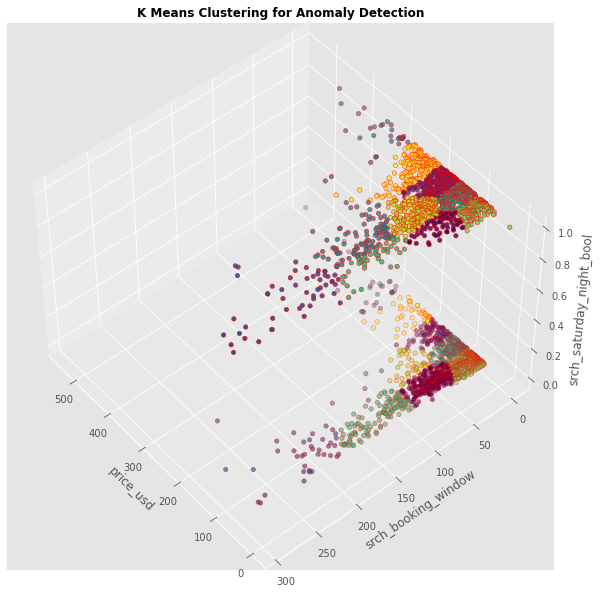

In [26]:
#Plotting
fig = plt.figure(1, figsize=(8,8))
ax = Axes3D(fig, rect=[0, 0, 0.95, 1], elev=49, azim=140)
ax.scatter(X.iloc[:,0], X.iloc[:,1], X.iloc[:,2], c=labels.astype(np.float), edgecolor="r")
ax.set_xlabel("price_usd")
ax.set_ylabel("srch_booking_window")
ax.set_zlabel("srch_saturday_night_bool")
plt.title("K Means Clustering for Anomaly Detection", fontsize=12, fontweight="bold");

In [28]:
from sklearn.preprocessing import StandardScaler

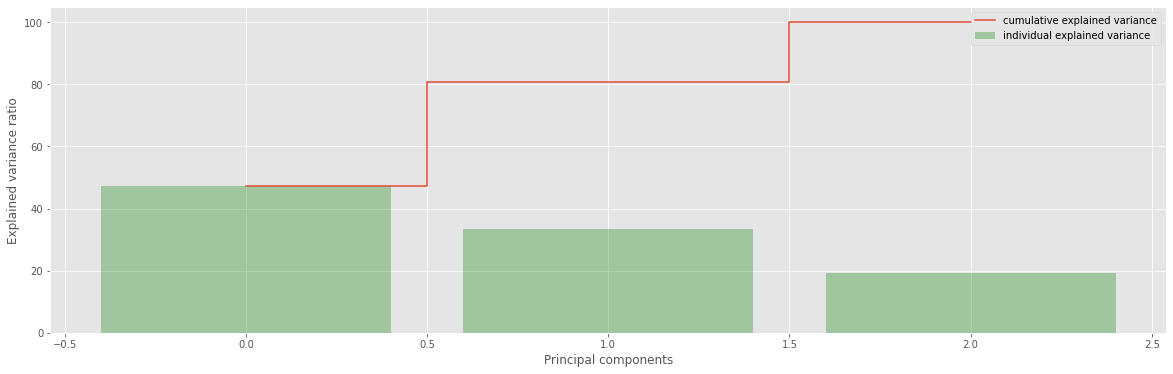

In [29]:
data = df[['price_usd', 'srch_booking_window', 'srch_saturday_night_bool']]
X = data.values
X_std = StandardScaler().fit_transform(X)
mean_vec = np.mean(X_std, axis=0)
cov_mat = np.cov(X_std.T)
eig_vals, eig_vecs = np.linalg.eig(cov_mat)
eig_pairs = [ (np.abs(eig_vals[i]),eig_vecs[:,i]) for i in range(len(eig_vals))]
eig_pairs.sort(key = lambda x: x[0], reverse= True)
tot = sum(eig_vals)
var_exp = [(i/tot)*100 for i in sorted(eig_vals, reverse=True)] # Individual explained variance
cum_var_exp = np.cumsum(var_exp) # Cumulative explained variance

plt.figure(figsize=(20, 6))
plt.bar(range(len(var_exp)), var_exp, alpha=0.3, align='center', label='individual explained variance', color = 'g')
plt.step(range(len(cum_var_exp)), cum_var_exp, where='mid',label='cumulative explained variance')
plt.ylabel('Explained variance ratio')
plt.xlabel('Principal components')
plt.legend(loc='best')
plt.show();

- 두개의 컴포넌트가 전체의 80%의 표현력을 포함

PCA를 구동하여 2D 상에서 군집결과를 살펴본다.

In [30]:
from sklearn.decomposition import PCA

In [31]:
# Take useful feature and standardize them
data = df[['price_usd', 'srch_booking_window', 'srch_saturday_night_bool']]
X_std = StandardScaler().fit_transform(X)
data = pd.DataFrame(X_std)
# reduce to 2 important features
pca = PCA(n_components=2)
data = pca.fit_transform(data)
# standardize these 2 new features
scaler = StandardScaler()
np_scaled = scaler.fit_transform(data)
data = pd.DataFrame(np_scaled)

In [32]:
df.head()

,date_time,price_usd,srch_booking_window,srch_saturday_night_bool
0,2013-03-14 11:27:28,206.0,99,1
1,2013-01-03 20:48:24,186.0,6,0
2,2013-01-19 16:51:27,61.0,1,0
3,2013-01-26 11:34:23,72.0,116,0
4,2013-04-29 09:39:50,246.0,245,0


In [33]:
kmeans = [KMeans(n_clusters=i).fit(data) for i in n_cluster]
df['cluster'] = kmeans[9].predict(data)
df.index = data.index
df['pca1'] = data[0]
df['pca2'] = data[1]
df['cluster'].value_counts()

5    663
0    593
1    429
3    354
6    353
8    212
7    150
2    150
9     79
4     65
Name: cluster, dtype: int64

In [34]:
df.head()

,date_time,price_usd,srch_booking_window,srch_saturday_night_bool,cluster,pca1,pca2
0,2013-03-14 11:27:28,206.0,99,1,7,1.507151,1.377635
1,2013-01-03 20:48:24,186.0,6,0,1,0.232739,-0.893155
2,2013-01-19 16:51:27,61.0,1,0,5,-1.115143,-0.884099
3,2013-01-26 11:34:23,72.0,116,0,2,-1.148993,1.555646
4,2013-04-29 09:39:50,246.0,245,0,4,0.564842,4.142935


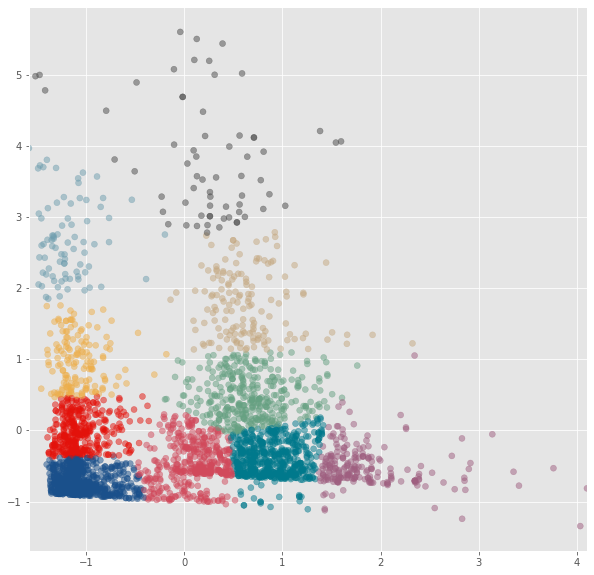

In [36]:
# plot the different clusters with the 2 main features
fig, ax = plt.subplots(figsize=(10,10))
#colors = {0:'red', 1:'blue', 2:'green', 3:'pink', 4:'black', 5:'orange', 
#          6:'cyan', 7:'yellow', 8:'brown', 9:'purple', 10:'white', 11: 'grey'}
ax.scatter(df['pca1'], df['pca2'], c=df["cluster"].apply(lambda x: colors[x]), 
           alpha = 0.5)
ax.autoscale(enable=True, axis='x', tight=True)
plt.show();

클러스터의 중심점에서의 거리를 계산하는 함수 만들기

In [37]:
data.head()

,0,1
0,1.507151,1.377635
1,0.232739,-0.893155
2,-1.115143,-0.884099
3,-1.148993,1.555646
4,0.564842,4.142935


**클러스트링 기반 이상탐지 방법의 기본 가정은 정상 데이터는 특정 클러스터에 포함되는 반면 이상치는 클러스터에 포함되지 않거나 작은 클러스터에 포함된다는 것에서 시작된다.**  
이상탐지 절차는 다음과 같다.  
- 각 포인트에서 가장 가까운 클러스터의 centroid와의 거리를 계산한다. 거리가 멀면 이상으로 간주한다.
- outliers_fraction을 사용하여 해당 비율 만큼 이상치가 존재한다고 가정한다. 여기서는 0.01로 설정하였다. z score 3 부근 값이기 때문이다.(??)  
- outliers_fraction을 사용하여 number_of_outliers를 계산한다.  
- 이상치의 최소 거리인 threshold를 계산한다.  
- 거리를 기준으로 anomaly 계산
- 이상치를 클러스터 관점에서 시각화  
- 이상치를 시계열 관점에서 시각화

In [38]:
def getDistanceByPoint(data, model):
    distance = []
    for i in range(0, len(data)):
        Xa = np.array(data.loc[i])
        Xb = model.cluster_centers_[model.labels_[i]-1]
        distance.append(np.linalg.norm(Xa-Xb))
        
    return pd.Series(distance)

In [39]:
outliers_fraction = 0.01
# get the distance between each point and its nearest centroid. The biggest distances are considered as anomaly
distance = getDistanceByPoint(data, kmeans[9])

In [40]:
distance

0       2.918164
1       0.825507
2       4.879315
3       2.376976
4       3.675161
          ...   
3043    1.871363
3044    1.548308
3045    0.544246
3046    1.068012
3047    1.795942
Length: 3048, dtype: float64

In [41]:
number_of_outliers = int(outliers_fraction*len(distance))
threshold = distance.nlargest(number_of_outliers).min()
# anomaly1 contain the anomaly result of the above method Cluster (0:normal, 1:anomaly) 
df['anomaly1'] = (distance >= threshold).astype(int)

In [43]:
df.head(2)

,date_time,price_usd,srch_booking_window,srch_saturday_night_bool,cluster,pca1,pca2,anomaly1
0,2013-03-14 11:27:28,206.0,99,1,7,1.507151,1.377635,0
1,2013-01-03 20:48:24,186.0,6,0,1,0.232739,-0.893155,0


In [44]:
df[df['anomaly1']==1]

,date_time,price_usd,srch_booking_window,srch_saturday_night_bool,cluster,pca1,pca2,anomaly1
28,2013-05-17 17:25:15,62.0,221,0,9,-1.397096,3.801772,1
97,2013-01-14 13:40:16,55.0,217,0,9,-1.467627,3.723030,1
107,2012-11-18 20:04:54,46.0,0,0,5,-1.276357,-0.891534,1
147,2013-01-12 21:45:00,44.0,1,0,5,-1.299360,-0.868381,1
248,2013-01-02 03:55:26,43.0,0,0,5,-1.308866,-0.888760,1
434,2013-05-01 13:51:31,50.0,0,0,5,-1.233012,-0.895232,1
481,2012-11-20 14:29:35,46.0,0,0,5,-1.276357,-0.891534,1
597,2013-05-22 15:34:59,62.0,277,0,4,-1.471624,4.994775,1
763,2013-01-17 17:35:51,102.0,288,1,4,0.128644,5.500177,1
772,2012-11-24 08:57:57,40.0,1,0,5,-1.342706,-0.864683,1


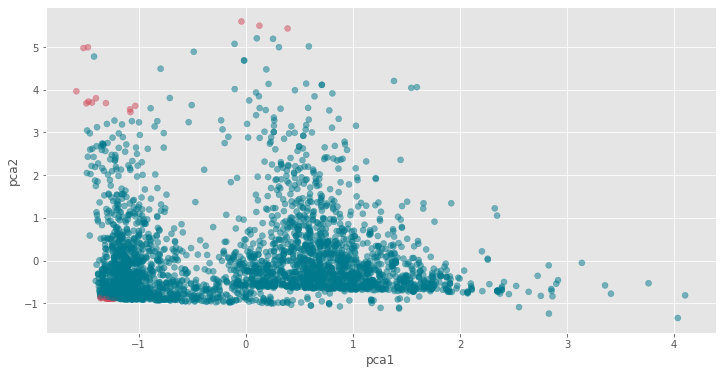

In [46]:
fig, ax = plt.subplots(figsize=(12,6))
# colors = {0:'blue', 1:'red'}
ax.scatter(df['pca1'], df['pca2'], c=df["anomaly1"].apply(lambda x: colors[x]),
          alpha = 0.5)
plt.xlabel('pca1')
plt.ylabel('pca2')
plt.show();

In [47]:
df.anomaly1.value_counts()

0    3018
1      30
Name: anomaly1, dtype: int64

In [48]:
df = df.sort_values('date_time')
df["date_time"] = pd.to_datetime(df["date_time"])
df['date_time_int'] = df.date_time.astype(np.int64)

In [49]:
df.head(3)

,date_time,price_usd,srch_booking_window,srch_saturday_night_bool,cluster,pca1,pca2,anomaly1,date_time_int
1261,2012-11-01 02:48:30,84.0,19,0,5,-0.889864,-0.521900,0,1351738110000000000
22,2012-11-01 03:06:43,78.0,16,1,1,0.230566,-0.272218,0,1351739203000000000
1073,2012-11-01 09:04:18,114.0,56,1,3,0.567439,0.546642,0,1351760658000000000


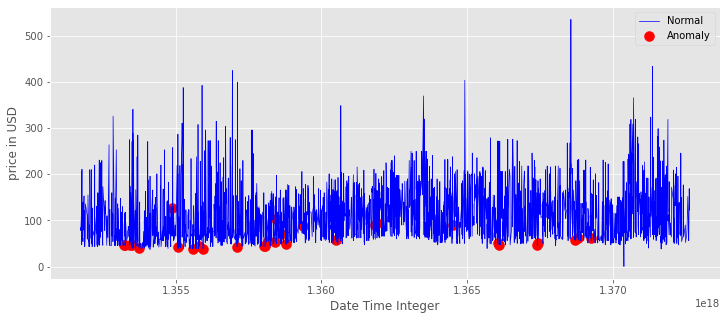

In [54]:
fig, ax = plt.subplots(figsize = (12, 5))
a = df.loc[df['anomaly1']==1, ['date_time_int', 'price_usd']]
ax.scatter(a['date_time_int'],a['price_usd'], color='red', label='Anomaly', s = 100)
ax.plot(df['date_time_int'], df['price_usd'], color='blue', 
        label='Normal',linewidth=0.7)
plt.xlabel('Date Time Integer')
plt.ylabel('price in USD')
plt.legend()
plt.show();

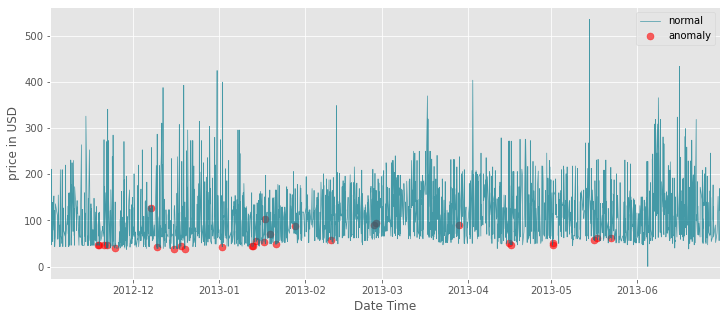

In [55]:
a = df.loc[df['anomaly1']==1, ['date_time', 'price_usd']]

fig, ax = plt.subplots(figsize = (12, 5))
ax.scatter(a['date_time'], a['price_usd'], color = 'red', label = 'anomaly', s = 50,
          alpha = 0.6)
ax.plot(df['date_time'], df['price_usd'], color=colors[0], label='normal',linewidth=0.7,
       alpha = 0.7)
ax.autoscale(enable=True, axis='x', tight=True)
plt.xlabel('Date Time')
plt.ylabel('price in USD')
plt.legend()
plt.show();

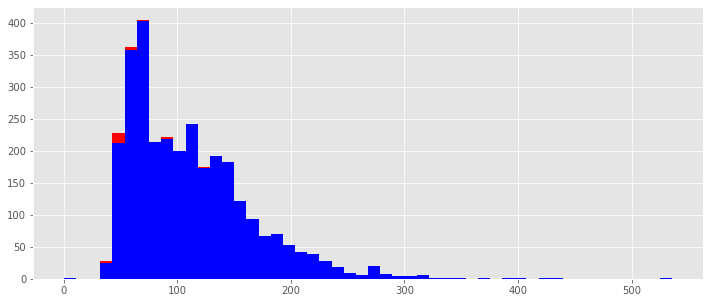

In [57]:
a = df.loc[df['anomaly1'] == 0, 'price_usd']
b = df.loc[df['anomaly1'] == 1, 'price_usd']

fig, axs = plt.subplots(figsize=(12,5))
axs.hist([a,b], bins=50, stacked=True, color=['blue', 'red'])
plt.show();

#### 2. Isolation forest for anomaly detection   
IF 기반 방법은 이상 샘플을 단독으로 분리하기 위해 사용되는 트리의 깊이를 활용한다.

In [58]:
from sklearn.ensemble import IsolationForest

In [59]:
data = df[['price_usd', 'srch_booking_window', 'srch_saturday_night_bool']]

In [60]:
scaler = StandardScaler()
np_scaled = scaler.fit_transform(data)
data = pd.DataFrame(np_scaled)

In [61]:
data.head()

,0,1,2
0,-0.493115,-0.391925,-1.050485
1,-0.602114,-0.456919,0.951941
2,0.051883,0.409666,0.951941
3,-0.638447,0.409666,0.951941
4,0.306215,-0.803553,0.951941


In [62]:
# train isolation forest
model =  IsolationForest(contamination=outliers_fraction)
model.fit(data)

IsolationForest(contamination=0.01)

In [63]:
df['anomaly2'] = pd.Series(model.predict(data))

In [64]:
df['anomaly2'].value_counts()

 1    3017
-1      31
Name: anomaly2, dtype: int64

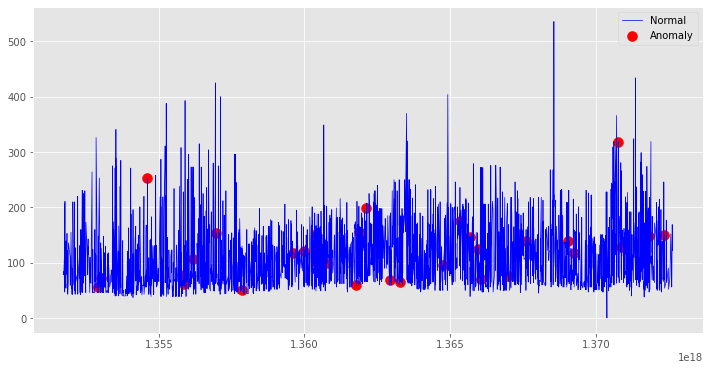

In [65]:
fig, ax = plt.subplots(figsize=(12,6))

a = df.loc[df['anomaly2'] == -1, ['date_time_int', 'price_usd']] #anomaly

ax.plot(df['date_time_int'], df['price_usd'], color='blue', label = 'Normal',
        linewidth=0.7)
ax.scatter(a['date_time_int'],a['price_usd'], color='red', label = 'Anomaly', 
           s = 100)
plt.legend()
plt.show();

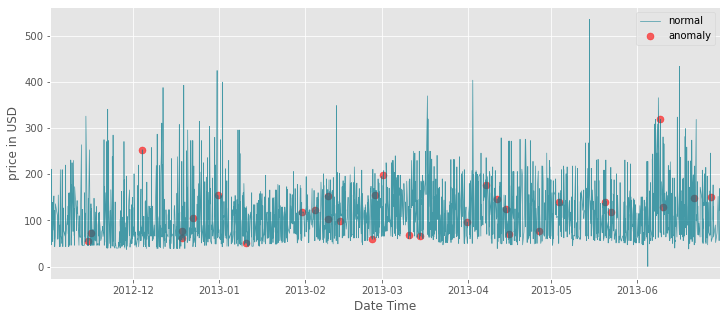

In [66]:
a = df.loc[df['anomaly2']==-1, ['date_time', 'price_usd']]

fig, ax = plt.subplots(figsize = (12, 5))
ax.scatter(a['date_time'], a['price_usd'], color = 'red', label = 'anomaly', s = 50,
          alpha = 0.6)
ax.plot(df['date_time'], df['price_usd'], color=colors[0], label='normal',linewidth=0.7,
       alpha = 0.7)
ax.autoscale(enable=True, axis='x', tight=True)
plt.xlabel('Date Time')
plt.ylabel('price in USD')
plt.legend()
plt.show();

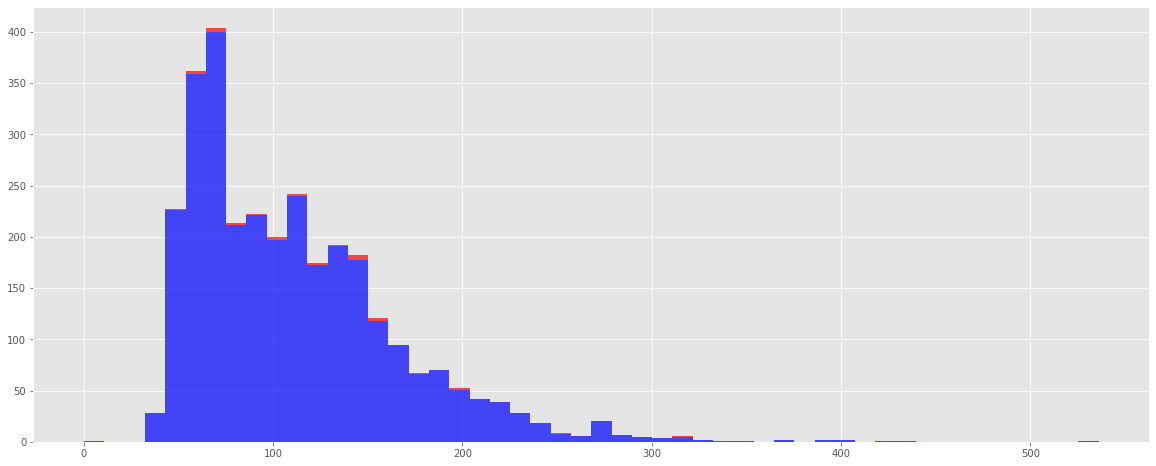

In [68]:
# visualisation of anomaly with avg price repartition
a = df.loc[df['anomaly2'] == 1, 'price_usd']
b = df.loc[df['anomaly2'] == -1, 'price_usd']

fig, axs = plt.subplots(figsize=(20,8))
axs.hist([a,b], bins=50, stacked=True, color=['blue', 'red'], alpha = 0.7)
plt.show();

#### 3. Support Vector Machine-Based Anomaly Detection

#### One class SVM  
- Unsupervised Outlier Detection.  
- Estimate the support of a high-dimensional distribution.  
- The implementation is based on libsvm.  

In [69]:
from sklearn.svm import OneClassSVM

In [70]:
data = df[['price_usd', 'srch_booking_window', 'srch_saturday_night_bool']]

In [71]:
scaler = StandardScaler()
np_scaled = scaler.fit_transform(data)
data = pd.DataFrame(np_scaled)

In [72]:
model = OneClassSVM(nu=outliers_fraction, kernel="rbf", gamma=0.01)
model.fit(data)

OneClassSVM(gamma=0.01, nu=0.01)

In [73]:
df['anomaly3'] = pd.Series(model.predict(data))

In [74]:
df.head(3)

,date_time,price_usd,srch_booking_window,srch_saturday_night_bool,cluster,pca1,pca2,anomaly1,date_time_int,anomaly2,anomaly3
1261,2012-11-01 02:48:30,84.0,19,0,5,-0.889864,-0.521900,0,1351738110000000000,1,1
22,2012-11-01 03:06:43,78.0,16,1,1,0.230566,-0.272218,0,1351739203000000000,1,1
1073,2012-11-01 09:04:18,114.0,56,1,3,0.567439,0.546642,0,1351760658000000000,1,1


In [75]:
df['anomaly3'].value_counts()

 1    3017
-1      31
Name: anomaly3, dtype: int64

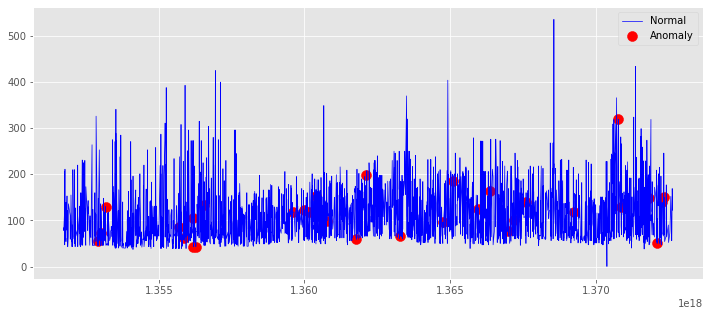

In [76]:
fig, ax = plt.subplots(figsize=(12, 5))

a = df.loc[df['anomaly3'] == -1, ['date_time_int', 'price_usd']] #anomaly

ax.plot(df['date_time_int'], df['price_usd'], color='blue', label ='Normal', linewidth = 0.7)
ax.scatter(a['date_time_int'],a['price_usd'], color='red', label = 'Anomaly', s = 100)
plt.legend()
plt.show();

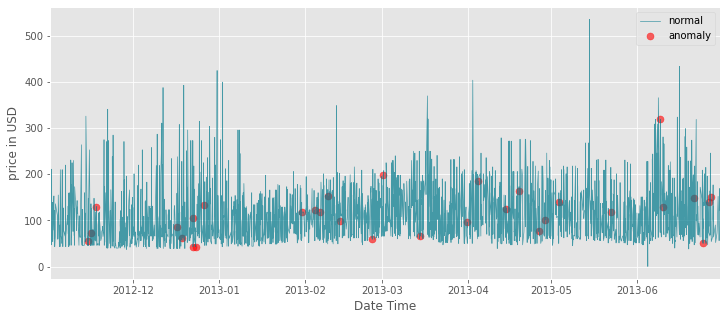

In [77]:
a = df.loc[df['anomaly3']==-1, ['date_time', 'price_usd']]

fig, ax = plt.subplots(figsize = (12, 5))
ax.scatter(a['date_time'], a['price_usd'], color = 'red', label = 'anomaly', s = 50,
          alpha = 0.6)
ax.plot(df['date_time'], df['price_usd'], color=colors[0], label='normal',linewidth=0.7,
       alpha = 0.7)
ax.autoscale(enable=True, axis='x', tight=True)
plt.xlabel('Date Time')
plt.ylabel('price in USD')
plt.legend()
plt.show();

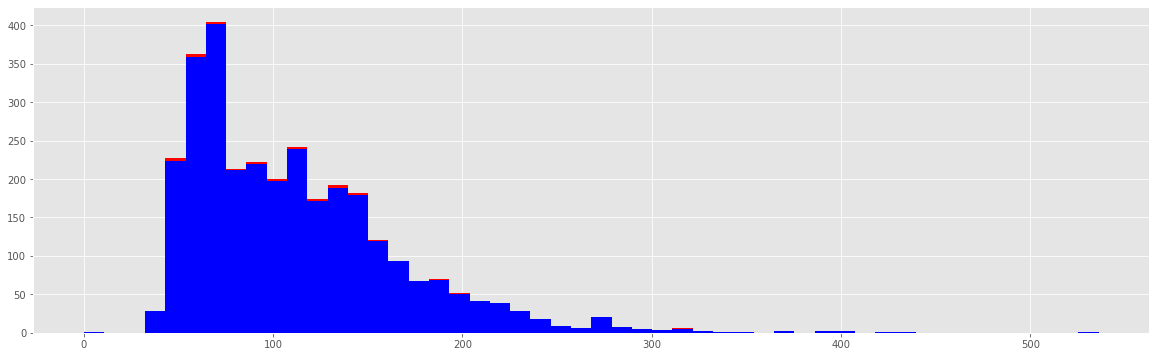

In [78]:
a = df.loc[df['anomaly3'] == 1, 'price_usd']
b = df.loc[df['anomaly3'] == -1, 'price_usd']

fig, axs = plt.subplots(figsize=(20,6))
axs.hist([a,b], bins=50, stacked=True, color=['blue', 'red'])
plt.show();

#### 4. Anomaly Detection using Gaussian Distribution

가우시안분포(또는 정규분포)를 사용하는 방법은 우리가 사용하는 데이터가 정규분포를 따른다고 가정한다. 싸이킷런의 covariance.EllipticEnvelope은 데이터의 분포를 사용하는 방법이다. 이때 데이터가 정규분포를 따른다고 가정한다.

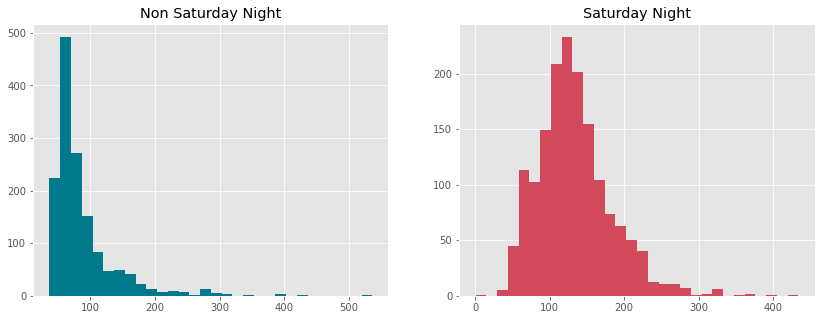

In [81]:
df_class0 = df.loc[df['srch_saturday_night_bool'] == 0, 'price_usd']
df_class1 = df.loc[df['srch_saturday_night_bool'] == 1, 'price_usd']

fig, axs = plt.subplots(1,2, figsize= (14, 5))
df_class0.hist(ax=axs[0], bins=30, color = colors[0])
df_class1.hist(ax=axs[1], bins=30, color = colors[1])
axs[0].set_title("Non Saturday Night")
axs[1].set_title("Saturday Night")
plt.show()

In [86]:
from sklearn.covariance import EllipticEnvelope

In [87]:
envelope =  EllipticEnvelope(contamination = outliers_fraction) 
X_train = df_class0.values.reshape(-1,1)
envelope.fit(X_train)
df_class0 = pd.DataFrame(df_class0)
df_class0['deviation'] = envelope.decision_function(X_train)
df_class0['anomaly'] = envelope.predict(X_train)

envelope =  EllipticEnvelope(contamination = outliers_fraction) 
X_train = df_class1.values.reshape(-1,1)
envelope.fit(X_train)
df_class1 = pd.DataFrame(df_class1)
df_class1['deviation'] = envelope.decision_function(X_train)
df_class1['anomaly'] = envelope.predict(X_train)

In [88]:
display(df_class0.head(3))
display(df_class1.head(3))

,price_usd,deviation,anomaly
1261,84.0,195.732118,1
1277,47.0,195.090776,1
673,98.0,193.029381,1


,price_usd,deviation,anomaly
22,78.0,13.721464,1
1073,114.0,15.054646,1
1632,76.0,13.599793,1


In [90]:
print(df_class0['anomaly'].value_counts())
print(df_class1['anomaly'].value_counts())

 1    1434
-1      15
Name: anomaly, dtype: int64
 1    1583
-1      16
Name: anomaly, dtype: int64


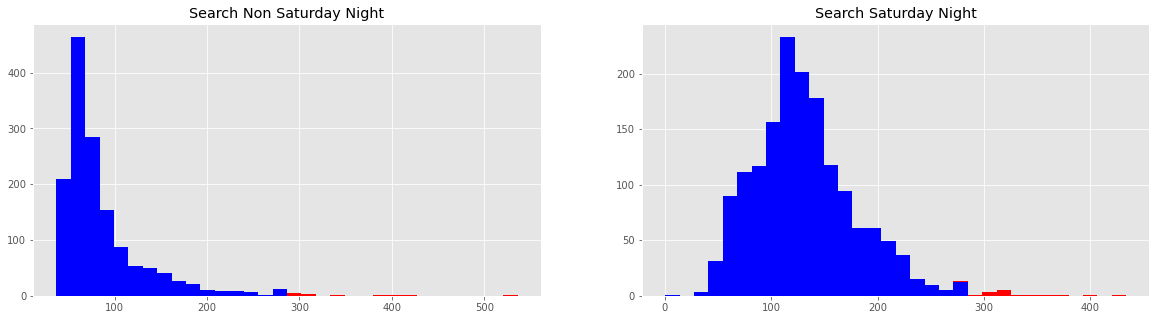

In [91]:
# plot the price repartition by categories with anomalies
a0 = df_class0.loc[df_class0['anomaly'] == 1, 'price_usd']
b0 = df_class0.loc[df_class0['anomaly'] == -1, 'price_usd']

a2 = df_class1.loc[df_class1['anomaly'] == 1, 'price_usd']
b2 = df_class1.loc[df_class1['anomaly'] == -1, 'price_usd']

fig, axs = plt.subplots(1,2, figsize= (20,5))
axs[0].hist([a0,b0], bins=32, stacked=True, color=['blue', 'red'])
axs[1].hist([a2,b2], bins=32, stacked=True, color=['blue', 'red'])
axs[0].set_title("Search Non Saturday Night")
axs[1].set_title("Search Saturday Night")
plt.show();

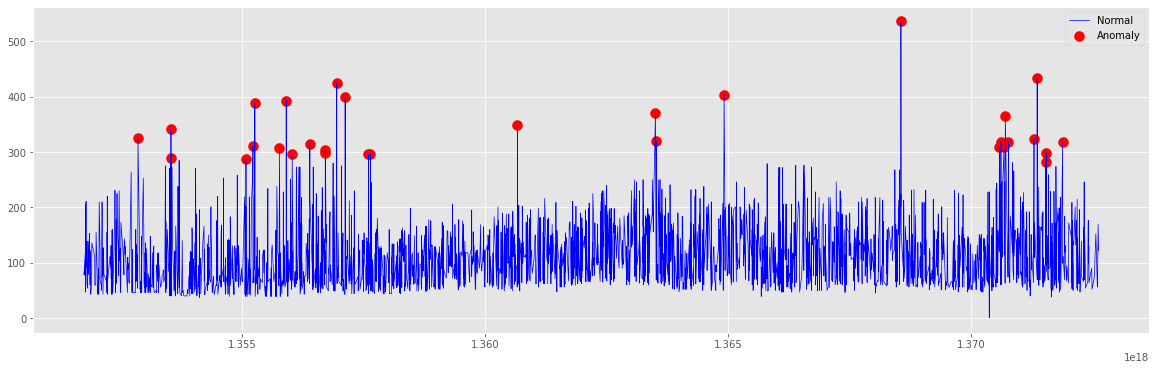

In [92]:
# add the data to the main 
df_class = pd.concat([df_class0, df_class1])
df['anomaly5'] = df_class['anomaly']
# df['anomaly5'] = np.array(df['anomaly22'] == -1).astype(int)
fig, ax = plt.subplots(figsize=(20, 6))
a = df.loc[df['anomaly5'] == -1, ('date_time_int', 'price_usd')] #anomaly
ax.plot(df['date_time_int'], df['price_usd'], color='blue', label='Normal', linewidth = 0.7)
ax.scatter(a['date_time_int'],a['price_usd'], color='red', label='Anomaly', s = 100)
plt.legend()
plt.show();